In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing import image
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
import urllib.request
import pickle
import time
from sklearn.decomposition import PCA
import random
from scipy.spatial import distance
import matplotlib.image as mpimg


In [ ]:
os.chdir("/content/drive/MyDrive/eyewear")

In [ ]:
itg_eyewear = pd.read_csv("eyewear_ml_challenge.csv")
itg_eyewear.head()


,Unnamed: 0,product_name,product_id,parent_category,Image_Front,frame_shape
0,0,Vintage Persona C4,7641,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
1,1,Vintage Crazy-X C2 Red,7643,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
2,2,Jialedi Eyewear 1086 C8 Blue,8254,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
3,3,Jialedi Eyewear 1086 C6 Red,8255,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
4,4,Jialedi Eyewear 1086 C4 Tortoise Transperent,8256,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle


In [ ]:
itg_eyewear.describe()

In [ ]:
for i, url in enumerate(itg_eyewear["Image_Front"]):
  try:
    urllib.request.urlretrieve(url, str(i)+".png")
  except:
    pass



In [ ]:
model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 13s 0us/step


In [ ]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


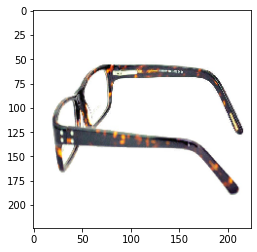

In [ ]:
img, x = load_image("0.png")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [ ]:
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

49152/35363 [=========================================] - 0s 0us/step
predicted black_widow with probability 0.196
predicted bow with probability 0.120
predicted tricycle with probability 0.089
predicted muzzle with probability 0.084
predicted stretcher with probability 0.051


In [ ]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

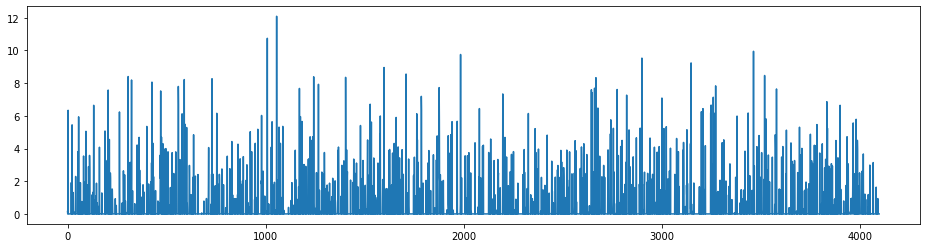

In [ ]:
img, x = load_image("0.png")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [ ]:

images_path = '.'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
'''
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]
'''

print("keeping %d images to analyze" % len(images))

keeping 5531 images to analyze


In [ ]:

tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    try:
      img, x = load_image(image_path);
      feat = feat_extractor.predict(x)[0]
      features.append(feat)
    except:
      pass

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


analyzing image 0 / 5531. Time: 0.0004 seconds.
analyzing image 500 / 5531. Time: 52.3520 seconds.
analyzing image 1000 / 5531. Time: 52.7464 seconds.
analyzing image 1500 / 5531. Time: 57.9265 seconds.
analyzing image 2000 / 5531. Time: 54.2869 seconds.
analyzing image 2500 / 5531. Time: 55.6184 seconds.
analyzing image 3000 / 5531. Time: 56.4256 seconds.
analyzing image 3500 / 5531. Time: 54.0333 seconds.
analyzing image 4000 / 5531. Time: 55.2164 seconds.
analyzing image 4500 / 5531. Time: 54.0489 seconds.
analyzing image 5000 / 5531. Time: 53.5360 seconds.
analyzing image 5500 / 5531. Time: 53.5516 seconds.
finished extracting features for 5531 images


In [ ]:

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_features = pca.transform(features)


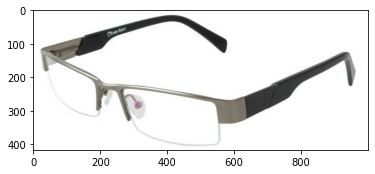

In [ ]:

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [ ]:


similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [ ]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

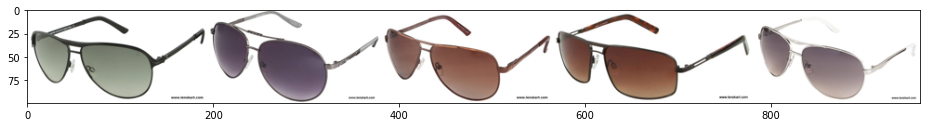

In [ ]:
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [ ]:

def get_closest_images(query_image_idx, num_results=10):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:num_results]
    return idx_closest

def get_concatenated_images1(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes[:5]:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image1 = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    thumbs=[]
    for idx in indexes[5:10]:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image2 = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image1 , concat_image2

Text(0.5, 1.0, 'result images')

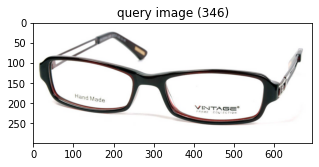

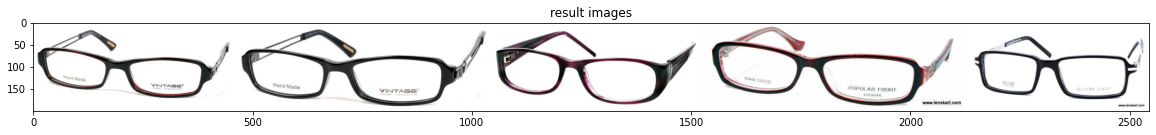

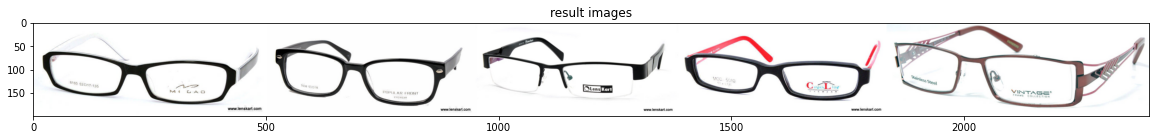

In [ ]:
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images1([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (20,10))
plt.imshow(results_image[0])
plt.title("result images")

# display the resulting images
plt.figure(figsize = (20,10))
plt.imshow(results_image[1])
plt.title("result images")

Enter url: http://tak-apps-dev.s3.amazonaws.com/recruitment/machine-learning/dataset/DSC_0049_4.JPG


Text(0.5, 1.0, 'result images')

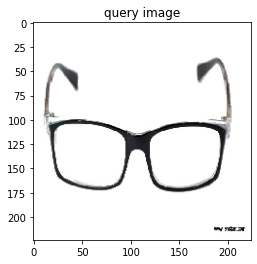

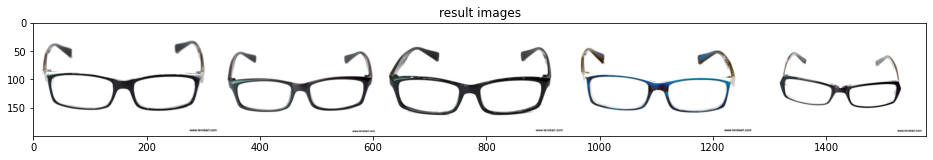

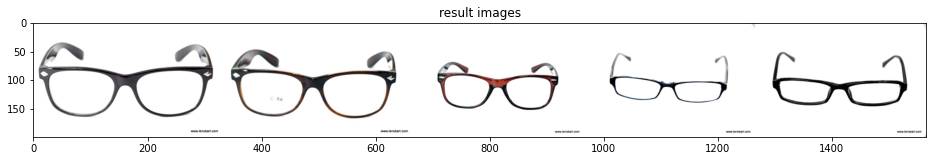

In [ ]:
try:
  urllib.request.urlretrieve(input("Enter url: "), "uploaded.png")
except:
  pass
# load image and extract features
new_image, x = load_image("uploaded.png")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:10]  # grab first 10
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure()
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image[0])
plt.title("result images")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image[1])
plt.title("result images")

Task 2

Predicted frame Shape:  Rectangle
Predicted Parent Category:  eyeframe
Original frame Shape:  Rectangle
Original Parent Category:  eyeframe


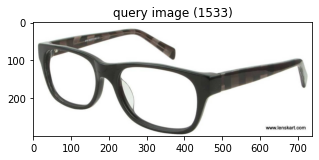

In [ ]:
query_image_idx = int(len(images) * random.random())
query_image = get_concatenated_images1([query_image_idx], 300)
idx_closest = get_closest_images(query_image_idx, 1000)


plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

#frame_shape
shapes = []
for id in idx_closest[:7]:
  shapes.append(itg_eyewear['frame_shape'][id])

#parent_category
category = []
for id in idx_closest:
  category.append(itg_eyewear['parent_category'][id])

print("Predicted frame Shape: ", max(shapes,key=shapes.count))
print("Predicted Parent Category: ", max(category,key=category.count))

print("Original frame Shape: ", itg_eyewear['frame_shape'][query_image_idx])
print("Original Parent Category: ", itg_eyewear['parent_category'][query_image_idx])


Enter url: http://tak-apps-dev.s3.amazonaws.com/recruitment/machine-learning/dataset/DSC_0201_3.JPG
Predicted frame Shape:  Wayfarer
Predicted Parent Category:  eyeframe


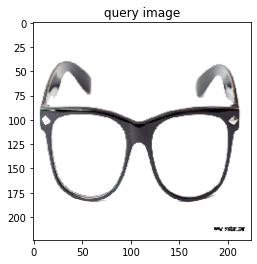

In [ ]:
try:
  urllib.request.urlretrieve(input("Enter url: "), "uploaded.png")
except:
  pass
# load image and extract features
new_image, x = load_image("uploaded.png")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:1000]  # grab first 1000

plt.figure()
plt.imshow(new_image)
plt.title("query image")

#frame_shape
shapes = []
for id in idx_closest[:7]:
  shapes.append(itg_eyewear['frame_shape'][id])

#parent_category
category = []
for id in idx_closest:
  category.append(itg_eyewear['parent_category'][id])

print("Predicted frame Shape: ", max(shapes,key=shapes.count))
print("Predicted Parent Category: ", max(category,key=category.count))

In [ ]:
pickle.dump([images, pca_features, pca], open('model.p', 'wb'))

In [ ]:
file = open("model.p", "rb")
images, pca_features, pca = pickle.load(file)